In [13]:
import random
import logging
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns

In [14]:
def requestPage(url: str):
        '''
        HTTP GET page with rotating user agents
        '''
        user_agent_list = [
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
            'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
            'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
        ]
        next_user_agent = random.choice(user_agent_list)

        try:
            header = {'user-agent': next_user_agent}
            response = requests.get(url, headers=header)  # Get page with random user agent
        except requests.exceptions.ConnectionError:
            logging.error("ConnectionError: Likely too many simultaneous connections")
            logging.warning("Not all pages have been scraped")
            return None

        if response.status_code != 200:
            logging.error("RESPONSE {} ON >>> {}".format(response.status_code, url))
            logging.warning("Not all pages have been scraped")
            return None

        return response

def toSoup(response):
        '''
        Make sure lxml parser has been installed
        '''
        return BeautifulSoup(response.text, "html.parser")

In [15]:
parkrun_id = 2813127
response = requestPage(f"https://www.parkrun.org.uk/parkrunner/{parkrun_id}/all/")
soup = toSoup(response)

In [25]:
tables = soup.find_all('table', {'id': 'results'})
results = tables[2]

Read the parkrun results table into a dataframe, and drop the minutes of each timestamp

In [17]:
df = pd.read_html(str(results))[0]
df.drop(columns=['PB?'])  # PB column not needed
df["Run Date"] = pd.to_datetime(df["Run Date"], format='%d/%m/%Y')
df["Time"].replace({r'\d\d:' : ''}, inplace=True, regex=True)
df["Time"] = df["Time"].astype(int)
df.head()

,Event,Run Date,Run Number,Pos,Time,AgeGrade,PB?
0,Frimley Lodge,2022-06-04,571,38,42,63.69%,NaN
1,Southampton,2022-05-28,443,89,56,62.98%,NaN
2,Southampton,2022-05-21,442,123,27,61.46%,NaN
3,Southampton,2022-05-14,441,95,22,61.70%,NaN
4,Southampton,2022-05-07,440,115,0,59.92%,NaN


## Bingo?

Let's take the columns we are interested in and sort them in date order

In [18]:
bingo_df = df[['Run Date', 'Time']]
bingo_df = bingo_df.rename(columns={'Run Date': 'date'})
bingo_df = bingo_df.sort_values(by='date', ascending=True)
bingo_df = bingo_df.reset_index(drop=True)
bingo_df.head()

,date,Time
0,2016-09-24,5
1,2016-10-01,55
2,2016-10-08,40
3,2016-10-15,19
4,2016-10-22,59


This is a test query to show that we can identify a run by the seconds part of the timestamp

In [19]:
bingo_df.loc[bingo_df['Time'] == 27]

,date,Time
187,2022-05-21,27


Remove duplicates on the number of seconds, the resulting table shows the date of when each time was first achieved

In [20]:
bingo_distinct = bingo_df.drop_duplicates(subset=['Time'])
bingo_distinct

,date,Time
0,2016-09-24,5
1,2016-10-01,55
2,2016-10-08,40
3,2016-10-15,19
4,2016-10-22,59
5,2016-10-29,52
6,2016-11-05,4
7,2016-11-19,34
9,2016-12-10,22
10,2016-12-17,44


A simple histogram with 60 bars showing the distribution of seconds

<AxesSubplot:xlabel='Time', ylabel='Count'>

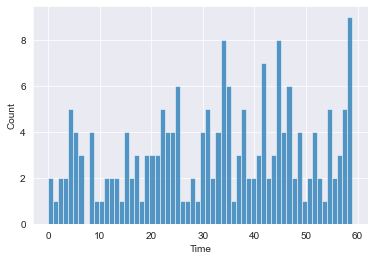

In [21]:
sns.histplot(bingo_df["Time"], bins=60)

A more broad look (6 bars, 10 second groups)

<AxesSubplot:xlabel='Time', ylabel='Count'>

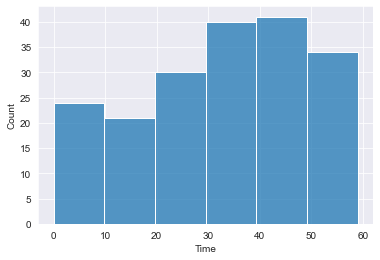

In [22]:
sns.histplot(bingo_df["Time"], bins=6)

### Cumulative

Let's create a new column to keep track of how many of the seconds we have covered at that point

In [23]:
cumulative_counter = lambda row: len(bingo_df.drop_duplicates(subset=['Time']).loc[bingo_df['date'] <= row['date']].index)
bingo_df['cumulative'] = bingo_df.apply(cumulative_counter, axis=1)

<AxesSubplot:ylabel='cumulative'>

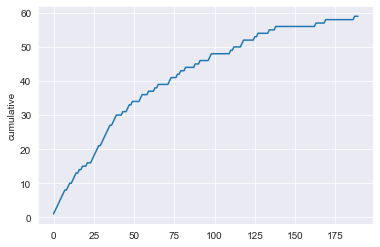

In [24]:
sns.lineplot(x=bingo_df.index, y=bingo_df['cumulative'])

The plot above shows the number of different seconds achieved by the run count